In [1]:
import malaya_speech
import numpy as np

In [2]:
y, sr = malaya_speech.utils.read.flac('speech/7021-79759-0004.flac')
len(y), sr

(391520, 16000)

### Load WebRTC

```python
def webrtc(
    aggressiveness: int = 3,
    sample_rate: int = 16000,
    minimum_amplitude: int = 100,
):
    """
    Load WebRTC VAD model.

    Parameters
    ----------
    aggressiveness: int, optional (default=3)
        an integer between 0 and 3.
        0 is the least aggressive about filtering out non-speech, 3 is the most aggressive.
    sample_rate: int, optional (default=16000)
        sample rate for samples.
    minimum_amplitude: int, optional (default=100)
        minimum_amplitude to assume a sample is a voice activity. Else, automatically False.

    Returns
    -------
    result : malaya_speech.model.webrtc.WEBRTC class
    """
```

WebRTC developed by Google, reportedly one of the best available, being fast, modern and free. Read more about pywebrtc at https://github.com/wiseman/py-webrtcvad.

In [3]:
vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))

### How to detect Voice Activity

In order to use available Malaya-Speech VAD models, we need to split our audio sample into really small chunks. 

For Google WebRTC, we need to split by every 30 ms. For deep learning, we trained on 30 ms, 90 ms and random length less than 300 ms.

To split an audio sample by giving time split, use, [malaya_speech.utils.generator.frames]()

```python
def frames(
    audio,
    frame_duration_ms: int = 30,
    sample_rate: int = 16000,
    append_ending_trail: bool = True,
):
    """
    Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and the sample rate.

    Parameters
    ----------

    audio: np.array / list
    frame_duration_ms: int, optional (default=30)
    sample_rate: int, optional (default=16000)
    append_ending_trail: bool, optional (default=True)
        if True, will append last trail and this last trail might not same length as `frame_duration_ms`.

    Returns
    -------
    result: List[malaya_speech.model.frame.FRAME]
    """
```

In [4]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))
frames = [(frame, vad(frame)) for frame in frames]

In [5]:
frames[:10]

[(<malaya_speech.model.frame.FRAME at 0x13efbd910>, True),
 (<malaya_speech.model.frame.FRAME at 0x13efbd950>, False),
 (<malaya_speech.model.frame.FRAME at 0x13efbd9d0>, False),
 (<malaya_speech.model.frame.FRAME at 0x13efbda10>, False),
 (<malaya_speech.model.frame.FRAME at 0x13efbda50>, False),
 (<malaya_speech.model.frame.FRAME at 0x13efbdad0>, False),
 (<malaya_speech.model.frame.FRAME at 0x13efbdb10>, False),
 (<malaya_speech.model.frame.FRAME at 0x13efbdb50>, False),
 (<malaya_speech.model.frame.FRAME at 0x13efbdb90>, False),
 (<malaya_speech.model.frame.FRAME at 0x13efbda90>, False)]

### VAD Visualization

We can visualize our audio sample to annotate which parts are active speech or not.

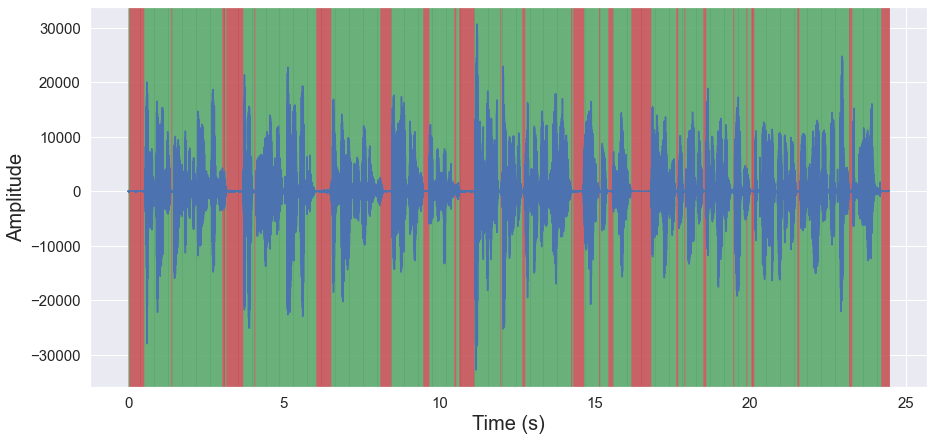

In [6]:
malaya_speech.extra.visualization.visualize_vad(y, frames, sr)

### Groupby VAD

To group small samples into larger samples, use [malaya_speech.vad.group_vad]()

In [7]:
grouped_vad = malaya_speech.vad.group_vad(frames)

In [8]:
len(frames), len(grouped_vad)

(816, 52)